In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [20]:
df = pd.read_csv("C:/Users/user/fin_project/db/recommend_ml_dataset.csv")
df.drop(["user_id", "news_id"], axis=1, inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106934 entries, 0 to 106933
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   userPnl           106934 non-null  int64  
 1   asset             106934 non-null  int64  
 2   investScore       106934 non-null  int64  
 3   topic_1           106934 non-null  float64
 4   topic_2           106934 non-null  float64
 5   topic_3           106934 non-null  float64
 6   topic_4           106934 non-null  float64
 7   topic_5           106934 non-null  float64
 8   topic_6           106934 non-null  float64
 9   topic_7           106934 non-null  float64
 10  topic_8           106934 non-null  float64
 11  topic_9           106934 non-null  float64
 12  main_topic        106934 non-null  int64  
 13  is_same_stock     106934 non-null  int64  
 14  is_same_industry  106934 non-null  int64  
 15  clicked           106934 non-null  int64  
dtypes: float64(9), int64

In [6]:
# 클래스별 개수
class_counts = df['clicked'].value_counts()
print("클래스별 개수:\n", class_counts)

# 클래스별 비율
class_ratio = df['clicked'].value_counts(normalize=True)
print("클래스별 비율:\n", class_ratio)

클래스별 개수:
 clicked
0    100008
1      6926
Name: count, dtype: int64
클래스별 비율:
 clicked
0    0.935231
1    0.064769
Name: proportion, dtype: float64


데이터 불균형이 있어서 임계값에 변화를 줘야하는데,  
임계값을 높게 설정하면 정밀도가 높아지고 재현율이 낮아짐  
FP(오탐)을 줄이는게 맞는 방향이라 판단해서 임계값을 바꿀거임

___________________________________________________________________

# 여기가 진짜!

In [246]:
df = pd.read_csv("recommend_ml_dataset_v2.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188913 entries, 0 to 188912
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   userPnl           188913 non-null  int64  
 1   asset             188913 non-null  int64  
 2   investScore       188913 non-null  int64  
 3   topic_1           188913 non-null  float64
 4   topic_2           188913 non-null  float64
 5   topic_3           188913 non-null  float64
 6   topic_4           188913 non-null  float64
 7   topic_5           188913 non-null  float64
 8   topic_6           188913 non-null  float64
 9   topic_7           188913 non-null  float64
 10  topic_8           188913 non-null  float64
 11  topic_9           188913 non-null  float64
 12  main_topic        188913 non-null  int64  
 13  is_same_stock     188913 non-null  int64  
 14  is_same_industry  188913 non-null  int64  
 15  clicked           188913 non-null  int64  
dtypes: float64(9), int64

In [248]:
# 클래스별 개수
class_counts = df['clicked'].value_counts()
print("클래스별 개수:\n", class_counts)

# 클래스별 비율
class_ratio = df['clicked'].value_counts(normalize=True)
print("클래스별 비율:\n", class_ratio)

클래스별 개수:
 clicked
0    151449
1     37464
Name: count, dtype: int64
클래스별 비율:
 clicked
0    0.801686
1    0.198314
Name: proportion, dtype: float64


In [249]:
from imblearn.over_sampling import SMOTE

X = df.drop("clicked", axis=1)
Y = df["clicked"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,  
    test_size=0.2,
    random_state=42
)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("리샘플링 후 클래스 분포:", pd.Series(y_train_res).value_counts())

리샘플링 후 클래스 분포: clicked
1    121244
0    121244
Name: count, dtype: int64


In [250]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [300, 500, 1000],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'class_weight': ['balanced'],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

lgbm = LGBMClassifier(random_state=42)
gs = GridSearchCV(
    lgbm,
    param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)
gs.fit(X_train_res, y_train_res)

print("베스트 파라미터:", gs.best_params_)
print("베스트 F1-score:", gs.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
베스트 파라미터: {'class_weight': 'balanced', 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.8}
베스트 F1-score: 0.9286113300842128


In [ ]:
# 모델 파라미터 설정
model = LGBMClassifier(
    class_weight='balanced'
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=10,
    colsample_bytree=1.0,
    subsample=0.8,
    early_stopping_rounds=50
)

# 학습
model.fit(
    X_train_res, y_train_res,
    eval_set=[(X_test, y_test)],
    eval_metric='auc'
)


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.966575	valid_0's binary_logloss: 0.236146


LGBMClassifier(class_weight='balanced', early_stopping_rounds=50,
               learning_rate=0.01, max_depth=10, n_estimators=1000,
               subsample=0.8)

In [262]:
# 확률 예측
y_proba = model.predict_proba(X_test)[:, 1]

# 최적 임계값 찾기
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_idx]

print(f"최적 임계값: {optimal_threshold:.2f}")

# 최적 임계값 적용
y_pred = (y_proba >= optimal_threshold).astype(int)

# 성능 리포트
print(f"정밀도: {precision_score(y_test, y_pred):.4f}")
print(f"재현율: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("혼동행렬")
print(confusion_matrix(y_test, y_pred))



최적 임계값: 0.58
정밀도: 0.7036
재현율: 0.9076
F1-score: 0.7927
ROC-AUC: 0.9666
혼동행렬
[[27308  2897]
 [  700  6878]]


c:\Users\user\anaconda3\envs\fin_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


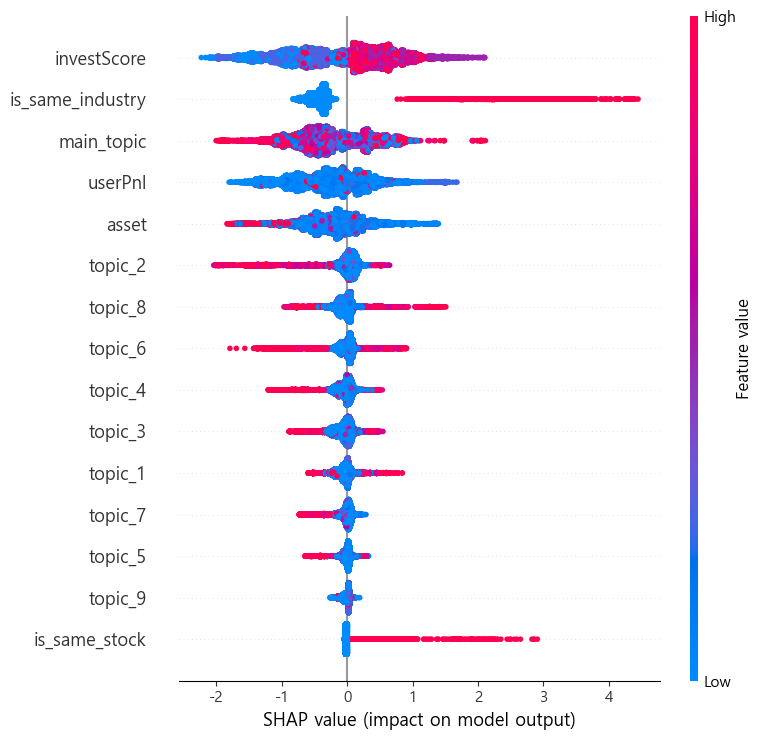

In [256]:
# SHAP 분석 예시 (추가 구현)
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


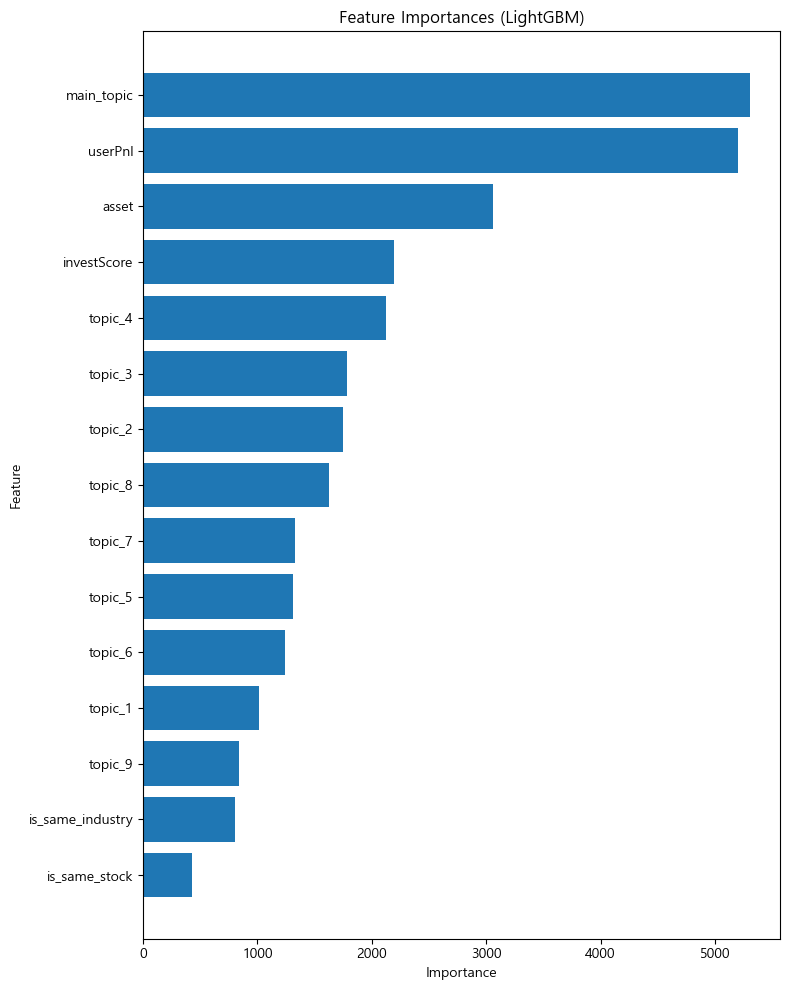

In [257]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X_train.columns

# 중요도 내림차순 정렬
indices = importances.argsort()[::-1]

plt.figure(figsize=(8, 10))
plt.title('Feature Importances (LightGBM)')
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # 중요도가 높은 피처가 위에 오도록
plt.tight_layout()
plt.show()


In [258]:
import pickle

# 모델 저장
with open("lgbm_model.pkl", "wb") as f:
    pickle.dump(model, f)

# 모델 불러오기
with open("lgbm_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)


In [263]:
y_test.head(30)

139266    0
113009    0
60163     0
43173     0
31906     0
93853     0
184489    0
5394      0
173759    1
148562    0
59697     0
76198     0
104895    0
117079    0
107781    0
125847    0
183366    0
183861    1
154772    0
5131      0
164572    1
156521    0
164222    0
58170     1
25961     0
21126     1
93238     1
43075     0
113122    0
48079     1
Name: clicked, dtype: int64

In [269]:
sample_idx = 183366
sample_data = X_test.loc[[sample_idx]]  

proba = model.predict_proba(sample_data)[:, 1]  # 클릭 확률값 추출

print("이 샘플의 클릭 확률:", proba[0])


이 샘플의 클릭 확률: 0.5823282167387673


________________________________________________________

# 여기는 가짜

피쳐 엔지니어링 추가

In [62]:
df = pd.read_csv("C:/Users/user/fin_project/db/recommend_ml_dataset.csv")
df.drop(["user_id", "news_id"], axis=1, inplace=True)

In [63]:
df['asset_log'] = np.log1p(df['asset'])
df['is_same_stock_and_industry'] = df['is_same_stock'] * df['is_same_industry']
df['is_same_stock_or_industry'] = df['is_same_industry'] + df['is_same_stock']
df['userPnl_x_is_same_stock'] = df['userPnl'] * df['is_same_stock']
df['userPnl_x_is_same_industry'] = df['userPnl'] * df['is_same_industry']
df['asset_log_x_is_same_stock'] = df['asset_log'] * df['is_same_stock']
df['asset_log_x_is_same_industry'] = df['asset_log'] * df['is_same_industry']
df['investScore_x_is_same_stock'] = df['investScore'] * df['is_same_stock']
df['investScore_x_is_same_industry'] = df['investScore'] * df['is_same_industry']

topic_cols = [f'topic_{i}' for i in range(1, 10)]
def get_main_topic_score(row):
    topic_num = int(row['main_topic'])
    return row[f'topic_{topic_num}']
df['score_of_main_topic'] = df.apply(get_main_topic_score, axis=1)

def get_other_topics_stats(row, stat_type='mean'):
    main_topic_num = int(row['main_topic'])
    other_topic_scores = []
    for col in topic_cols:
        current_topic_num = int(col.split('_')[1])
        if current_topic_num != main_topic_num:
            other_topic_scores.append(row[col])
    if not other_topic_scores: return np.nan
    if stat_type == 'mean': return np.mean(other_topic_scores)
    elif stat_type == 'max': return np.max(other_topic_scores)
    elif stat_type == 'min': return np.min(other_topic_scores)
    elif stat_type == 'std': return np.std(other_topic_scores) if len(other_topic_scores) > 1 else 0.0
    return np.nan

df['avg_score_other_topics'] = df.apply(lambda row: get_other_topics_stats(row, 'mean'), axis=1)
df['max_score_other_topics'] = df.apply(lambda row: get_other_topics_stats(row, 'max'), axis=1)
df['min_score_other_topics'] = df.apply(lambda row: get_other_topics_stats(row, 'min'), axis=1)
df['std_score_other_topics'] = df.apply(lambda row: get_other_topics_stats(row, 'std'), axis=1)
df['diff_main_vs_avg_other_topics'] = df['score_of_main_topic'] - df['avg_score_other_topics']
df['diff_main_vs_max_other_topics'] = df['score_of_main_topic'] - df['max_score_other_topics']


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106934 entries, 0 to 106933
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   userPnl                         106934 non-null  int64  
 1   asset                           106934 non-null  int64  
 2   investScore                     106934 non-null  int64  
 3   topic_1                         106934 non-null  float64
 4   topic_2                         106934 non-null  float64
 5   topic_3                         106934 non-null  float64
 6   topic_4                         106934 non-null  float64
 7   topic_5                         106934 non-null  float64
 8   topic_6                         106934 non-null  float64
 9   topic_7                         106934 non-null  float64
 10  topic_8                         106934 non-null  float64
 11  topic_9                         106934 non-null  float64
 12  main_topic      

In [65]:
from imblearn.over_sampling import SMOTE

X = df.drop(["clicked", "asset"], axis=1)
Y = df["clicked"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,  
    test_size=0.2,
    random_state=42
)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("리샘플링 후 클래스 분포:", pd.Series(y_train_res).value_counts())

리샘플링 후 클래스 분포: clicked
0    80042
1    80042
Name: count, dtype: int64


In [ ]:
from lightgbm import LGBMClassifier

# 모델 파라미터 설정
model = LGBMClassifier(
    random_state=42,
    class_weight='balanced',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    early_stopping_rounds=50
)

# 학습
model.fit(
    X_train_res, y_train_res,
    eval_set=[(X_test, y_test)],
    eval_metric='auc'
)


[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Number of positive: 80042, number of negative: 80042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4234
[LightGBM] [Info] Number of data points in the train set: 160084, number of used features: 30
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[90]	valid_0's auc: 0.986521	valid_0's binary_

LGBMClassifier(class_weight='balanced', early_stopping_rounds=50,
               learning_rate=0.05, max_depth=7, n_estimators=1000,
               random_state=42)

In [ ]:
# 확률 예측
y_proba = model.predict_proba(X_test)[:, 1]

# 최적 임계값 찾기
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_idx]

print(f"최적 임계값: {optimal_threshold:.2f}")

# 최적 임계값 적용
y_pred = (y_proba >= optimal_threshold).astype(int)

# 성능 리포트
print("성능 리포트")
print(f"정밀도: {precision_score(y_test, y_pred):.4f}")
print(f"재현율: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("혼동행렬")
print(confusion_matrix(y_test, y_pred))



최적 임계값: 0.80
🔍 성능 리포트
정밀도: 0.7507
재현율: 0.7417
F1-score: 0.7462
ROC-AUC: 0.9865

📊 혼동행렬
[[19616   350]
 [  367  1054]]


c:\Users\user\anaconda3\envs\fin_project\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


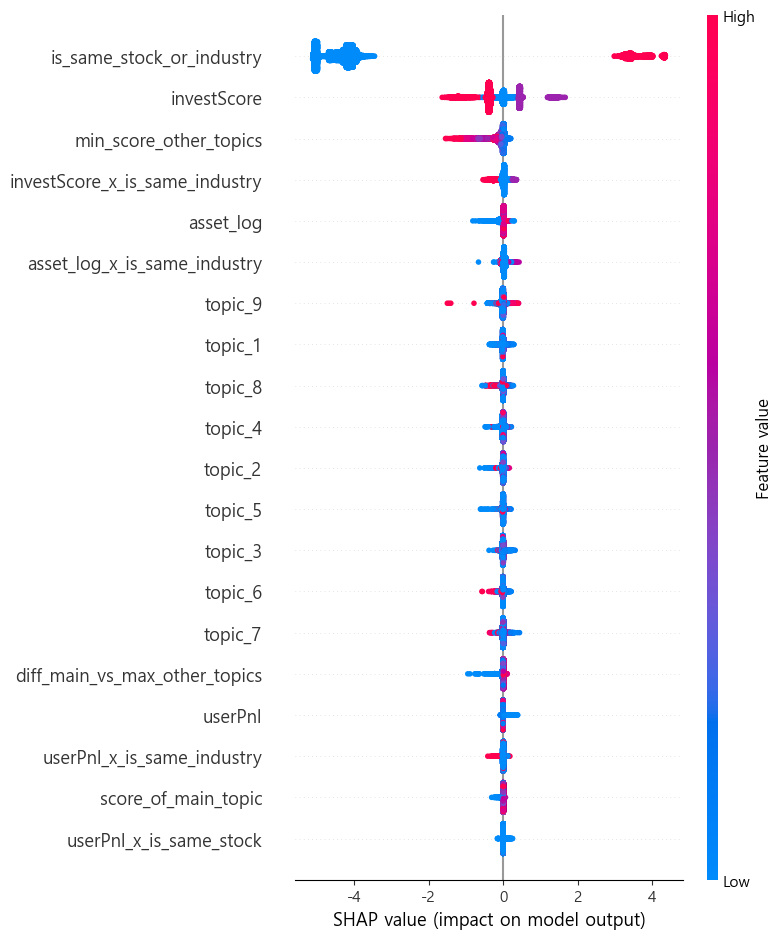

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


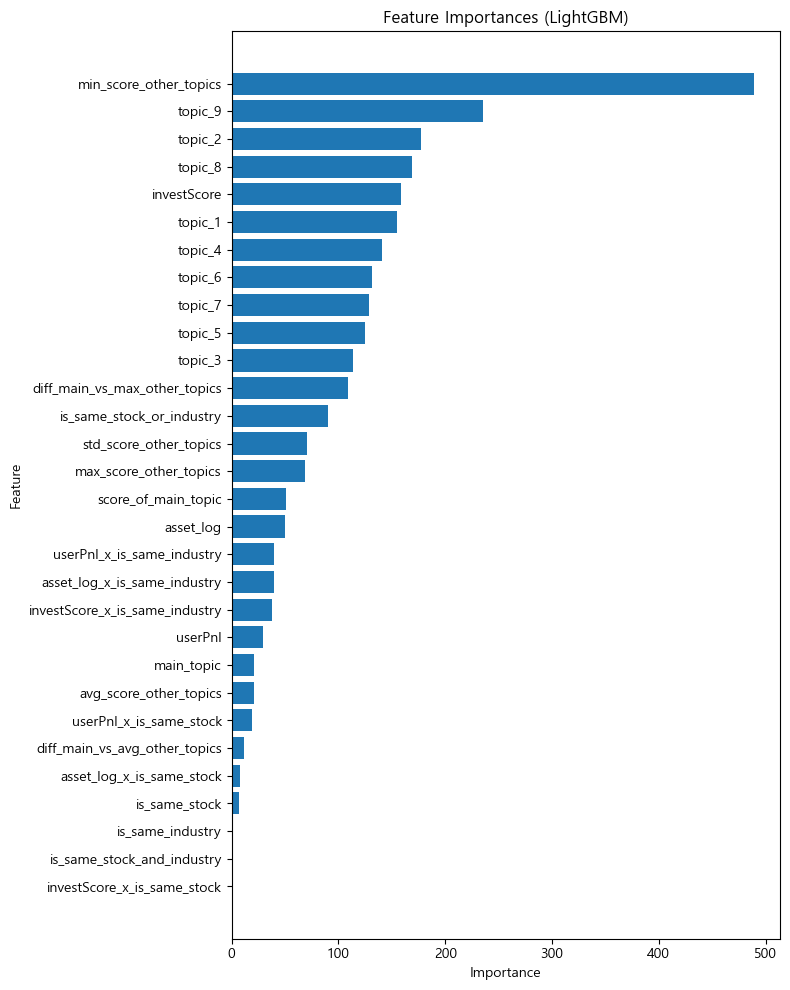

In [ ]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X_train.columns

# 중요도 내림차순 정렬
indices = importances.argsort()[::-1]

plt.figure(figsize=(8, 10))
plt.title('Feature Importances (LightGBM)')
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # 중요도가 높은 피처가 위에 오도록

plt.tight_layout()
plt.show()
